In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, factorial, jacobi

# define tool functions

## basis

In [2]:
# ============================================================
# Shifted-polynomial coefficients in x for:
#   P_{n-1}^{(alpha,beta)}(1 - 2x) = sum_{j=0}^{n-1} d_{n,j} x^j
# Special cases:
#   b=1      -> alpha=0, beta=0 (Legendre)
#   b=3/2    -> alpha=1, beta=0 (Jacobi)
# General (your basis construction): alpha = 2b - 2, beta = 0
# ============================================================

from functools import lru_cache
from numpy.polynomial import Polynomial, Legendre

def _is_half_integer(b: float, tol: float = 1e-12) -> bool:
    """True if b is an integer or half-integer within tolerance."""
    two_b = 2.0 * float(b)
    return abs(two_b - round(two_b)) < tol

def _b_key(b: float, tol: float = 1e-12) -> float:
    """
    Stable cache key for half-integers/integers:
      b = m/2  -> store as exact float m/2 (with m integer)
    """
    if not _is_half_integer(b, tol=tol):
        raise ValueError("This implementation supports integer/half-integer b (e.g., 1, 3/2, 2, 5/2, ...).")
    m = int(round(2.0 * float(b)))
    return m / 2.0

@lru_cache(maxsize=None)
def _d_coeffs_shifted_jacobi(n: int, b_key: float) -> np.ndarray:
    """
    Return d_{n,0..n-1} such that
      P_{n-1}^{(alpha,0)}(1-2x) = sum_j d_{n,j} x^j
    with alpha = 2b - 2, b = b_key (integer/half-integer).
    """
    if int(n) != n or n < 1:
        raise ValueError("n must be an integer >= 1.")
    n = int(n)

    b = float(b_key)
    alpha = 2.0 * b - 2.0
    beta  = 0.0

    # Use Legendre for the classic b=1 case (exact match to your original).
    if abs(b - 1.0) < 1e-15:
        P_t = Legendre.basis(n - 1).convert(kind=Polynomial)  # power basis in t
        a_m = P_t.coef                                       # ascending powers: sum_m a_m t^m
    else:
        # scipy.special.jacobi gives an orthopoly1d in variable t with descending power coeffs
        J = jacobi(n - 1, alpha, beta)  # P_{n-1}^{(alpha,beta)}(t)
        # J.c is descending powers; convert to numpy.polynomial.Polynomial (ascending)
        a_m = np.asarray(J.c[::-1], dtype=float)

    # Substitute t = 1 - 2x
    t_poly = Polynomial([1.0, -2.0])  # 1 - 2x
    p_x = Polynomial([0.0])
    for m, am in enumerate(a_m):
        if am != 0.0:
            p_x = p_x + am * (t_poly ** m)

    # d_{n,j} in ascending powers of x
    return np.asarray(p_x.coef, dtype=float)


# ============================================================
# Dimensionless basis ū_n(A) for general (half-integer) b
#
#   x(A) = 1/(1 + A^2)
#   ū_n(A) = (1/sqrt(pi)) * sqrt(2n + 2b - 3) * x^b * P_{n-1}^{(2b-2,0)}(1 - 2x)
#
# Physical:
#   u_n(Q) = a * ū_n(aQ)
# ============================================================

def u_n_A(n: int, A: np.ndarray, b: float = 1.0, print_coeff: bool = False):
    """
    Dimensionless basis ū_n(A) for half-integer/integer b.

    ū_n(A) = (1/sqrt(pi)) * sqrt(2n + 2b - 3) * x(A)^b * P_{n-1}^{(2b-2,0)}(1 - 2x(A)),
    x(A) = 1/(1 + A^2).

    Physical: u_n(Q) = a * ū_n(aQ).
    """
    if int(n) != n or n < 1:
        raise ValueError("n must be an integer >= 1.")
    n = int(n)

    bkey = _b_key(b)
    b = float(bkey)

    A = np.asarray(A, dtype=float)
    x = 1.0 / (1.0 + A * A)

    # p(x) = P_{n-1}^{(2b-2,0)}(1-2x) as power series in x
    d = _d_coeffs_shifted_jacobi(n, bkey)  # d_{n,j}
    if print_coeff:
        print(f"Coefficients of polynomial P_{n-1}^(2b-2,0): {d.astype(int)}")
    p = np.zeros_like(x)
    for dj in d[::-1]:
        p = p * x + dj

    pref = np.sqrt(2.0 * n + 2.0 * b - 3.0) / np.sqrt(np.pi)
    return pref * np.power(x, b) * p


# ============================================================
# Dimensionless Hankel-transform basis ũ̄_n(B) for general b
#
# Seed transform scaling (consistent with your b=1 code):
#   H{ (1 + A^2)^{-(b+j)} }  ∝  [1/(2^{b+j-1} Γ(b+j))] * B^{b+j-1} K_{b+j-1}(B)
#
# Expansion:
#   ū_n(A) = (1/sqrt(pi)) * sqrt(2n+2b-3) * sum_j d_{n,j} x^{b+j}
#
# Therefore:
#   ũ̄_n(B) = pref * sum_{j=0}^{n-1} d_{n,j} / (2^{b+j-1} Γ(b+j)) * B^{b+j-1} K_{b+j-1}(B)
#
# Physical:
#   ũ_n(k) = (1/a) * ũ̄_n(k/a)
# ============================================================

def u_tilde_n_B(n: int, B: np.ndarray, b: float = 1.0, print_coeff: bool = False):
    """
    Dimensionless Hankel-transform basis ũ̄_n(B) for half-integer/integer b.

    ũ̄_n(B) = pref * sum_{j=0}^{n-1} d_{n,j} / (2^{b+j-1} Γ(b+j)) * B^{b+j-1} K_{b+j-1}(B),
    pref = (1/sqrt(pi)) * sqrt(2n + 2b - 3).

    Physical: ũ_n(k) = (1/a) * ũ̄_n(k/a).
    """
    if int(n) != n or n < 1:
        raise ValueError("n must be an integer >= 1.")
    n = int(n)

    bkey = _b_key(b)
    b = float(bkey)

    B = np.asarray(B, dtype=float)
    B_safe = np.maximum(B, 1e-300)  # avoid kv(.,0) issues

    d = _d_coeffs_shifted_jacobi(n, bkey)
    if print_coeff:
        print(f"Coefficients of polynomial P_{n-1}^(2b-2,0): {d.astype(int)}")
    pref = np.sqrt(2.0 * n + 2.0 * b - 3.0) / np.sqrt(np.pi)

    out = np.zeros_like(B_safe)
    for j in range(n):
        nu = b + j - 1.0
        coef = pref * d[j] / ( (2.0 ** (b + j - 1.0)) * factorial(b + j - 1) )
        out += coef * (B_safe ** nu) * kv(nu, B_safe)

    return out


# ============================================================
# Physical-unit wrappers
# ============================================================

def u_n_Q(n: int, Q: np.ndarray, a: float, b: float = 1.0):
    """Physical u_n(Q): u_n(Q) = a * ū_n(aQ)."""
    a = float(a)
    return a * u_n_A(n, a * np.asarray(Q, float), b=b)

def u_tilde_n_k(n: int, k: np.ndarray, a: float, b: float = 1.0):
    """Physical ũ_n(k): ũ_n(k) = (1/a) * ũ̄_n(k/a)."""
    a = float(a)
    return (1.0 / a) * u_tilde_n_B(n, np.asarray(k, float) / a, b=b)


# ============================================================
# Quick checks
# ============================================================
if __name__ == "__main__":
    A = np.linspace(0, 10, 5)
    B = np.linspace(0.1, 10, 5)

    # b=1 should reproduce your original structure
    print("ū_3(A) b=1:", u_n_A(3, A, b=1.0))
    print("ũ̄_3(B) b=1:", u_tilde_n_B(3, B, b=1.0))

    # b=3/2 (half-integer)
    print("ū_3(A) b=3/2:", u_n_A(3, A, b=1.5))
    print("ũ̄_3(B) b=3/2:", u_tilde_n_B(3, B, b=1.5))
    
    for n in range(1, 9):
        u_n_A(n, A, b=1.5, print_coeff=True)
        # u_tilde_n_B(n, B, b=1.5, print_coeff=True)

ū_3(A) b=1: [1.26156626 0.04986469 0.03775511 0.01976697 0.01175608]
ũ̄_3(B) b=1: [1.22018099 0.10184592 0.05216591 0.00962797 0.00135184]
ū_3(A) b=3/2: [1.3819766  0.10867357 0.02661551 0.00891205 0.00392408]
ũ̄_3(B) b=3/2: [1.00870774 0.02845941 0.0699894  0.01766813 0.00299068]
Coefficients of polynomial P_0^(2b-2,0): [1]
Coefficients of polynomial P_1^(2b-2,0): [ 2 -3]
Coefficients of polynomial P_2^(2b-2,0): [  2 -12  10]
Coefficients of polynomial P_3^(2b-2,0): [  3 -30  60 -35]
Coefficients of polynomial P_4^(2b-2,0): [   5  -60  210 -280  126]
Coefficients of polynomial P_5^(2b-2,0): [    6  -104   560 -1260  1260  -462]
Coefficients of polynomial P_6^(2b-2,0): [    7  -168  1260 -4200  6930 -5544  1716]
Coefficients of polynomial P_7^(2b-2,0): [     8   -252   2520 -11550  27720 -36036  24024  -6435]


## coefficient extraction

In [3]:
from scipy.integrate import quad
from scipy.special import j0
from scipy.interpolate import interp1d

# ============================================================
# 1) estimate a scale 'a' from observed (Q, f(Q)) by locating a knee:
# ============================================================
def estimate_a_from_knee(Q_grid, fQ_grid, b=1.0, frac=0.5, n0=10):
    """
    Estimate a scale 'a' from observed (Q, f(Q)) by locating a knee:
      find Q* where f(Q*) = frac * f0, with f0 ~ median of first n0 points.

    Then match the width to (1 + a^2 Q^2)^(-b):
      a = (1/Q*) * sqrt(frac^(-1/b) - 1).

    Parameters
    ----------
    Q_grid : array-like, positive, increasing
    fQ_grid : array-like, same shape
    b : float
        Basis shape parameter (>0).
    frac : float
        Target fraction of the low-Q baseline (0<frac<1). Default 0.5.
    n0 : int
        Number of first points used to estimate baseline.

    Returns
    -------
    a_est : float
    Q_star : float
    f0 : float
    """
    Q = np.asarray(Q_grid, float)
    f = np.asarray(fQ_grid, float)

    if Q.ndim != 1 or f.shape != Q.shape:
        raise ValueError("Q_grid and fQ_grid must be 1D arrays with the same shape.")
    if np.any(Q <= 0):
        raise ValueError("Q_grid must be positive.")
    if not np.all(np.diff(Q) > 0):
        raise ValueError("Q_grid must be strictly increasing.")
    if not (0.0 < frac < 1.0):
        raise ValueError("frac must be in (0,1).")
    b = float(b)
    if not (b > 0):
        raise ValueError("b must be > 0.")

    n0 = int(min(max(n0, 2), len(Q)))
    f0 = float(np.median(f[:n0]))
    target = frac * f0

    f_s = f.copy()

    idx = np.where(f_s <= target)[0]
    if len(idx) == 0:
        # no knee within range -> fall back to geometric-midpoint in Q
        Q_star = float(np.sqrt(Q[0] * Q[-1]))
        # knee-match formula still needs a Q_star; use it
        a_est = (1.0 / Q_star) * np.sqrt(frac ** (-1.0 / b) - 1.0)
        return float(a_est), float(Q_star), f0

    i = int(idx[0])
    if i == 0:
        Q_star = float(Q[0])
        a_est = (1.0 / Q_star) * np.sqrt(frac ** (-1.0 / b) - 1.0)
        return float(a_est), float(Q_star), f0

    # interpolate knee location in logQ (stable for log-spaced grids)
    q1, q2 = Q[i - 1], Q[i]
    y1, y2 = f_s[i - 1], f_s[i]
    if y2 == y1:
        Q_star = float(q2)
    else:
        t = (target - y1) / (y2 - y1)
        logQ_star = np.log(q1) + (np.log(q2) - np.log(q1)) * t
        Q_star = float(np.exp(logQ_star))

    a_est = (1.0 / Q_star) * np.sqrt(frac ** (-1.0 / b) - 1.0)
    return float(a_est), float(Q_star), f0


# ============================================================
# 2) Projection onto your basis u_n_Q (assumed defined elsewhere)
#    a_n = ∫ f(Q) u_n(Q) 2πQ dQ
# ============================================================
def get_expansion_coefficients(
    fQ,
    n_max: int,
    a: float,
    Q_limit: float,
    b: float = 1.0,              # <-- NEW
    quad_limit: int = 200,
    epsabs: float = 1e-12,
    epsrel: float = 1e-10,
    mode: str = "split",          # "split" or "log"
    Q0: float | None = None,      # optional split point for "split" mode
    n_splits: int = 4,            # number of sub-intervals in "split" mode
):
    """
    Compute coefficients
        a_n = ∫_0^{Q_limit} f(Q) u_n(Q; a,b) (2πQ) dQ
    using scipy.integrate.quad.

    Parameters
    ----------
    fQ : callable(Q)->float
        Scalar-safe function f(Q).
    n_max : int
        Maximum basis index n (computes n=1..n_max).
    a : float
        Basis scale parameter used by u_n_Q.
    Q_limit : float
        Upper integration limit in Q.
    b : float
        Basis shape parameter (supports half-integers/integers if your u_n_Q does).
    quad_limit : int
        quad recursion limit.
    epsabs, epsrel : float
        Absolute/relative error tolerances passed to quad.
    mode : str
        "split": integrate over Q with sub-intervals (recommended default).
        "log":   integrate using Q = exp(t), t ∈ (-∞, log Q_limit], with Q clipped at Q_min.
    Q0 : float or None
        For "split" mode, optional characteristic split location. If None, uses Q0=1/a.
    n_splits : int
        For "split" mode, number of sub-intervals between 0 and Q_limit.

    Returns
    -------
    coeffs : (n_max,) ndarray
        Coefficients a_n for n=1..n_max.
    errs : (n_max,) ndarray
        quad error estimates for each coefficient.
    """
    if int(n_max) != n_max or n_max < 1:
        raise ValueError("n_max must be an integer >= 1.")
    n_max = int(n_max)

    a = float(a)
    Q_limit = float(Q_limit)
    if not (Q_limit > 0):
        raise ValueError("Q_limit must be > 0.")
    if a <= 0:
        raise ValueError("a must be > 0.")

    # choose a characteristic split scale near where x=1/(1+(aQ)^2) transitions
    if Q0 is None:
        Q0 = 1.0 / a
    Q0 = float(Q0)

    coeffs = np.zeros(n_max, dtype=float)
    errs   = np.zeros(n_max, dtype=float)

    two_pi = 2.0 * np.pi

    if mode not in ("split", "log"):
        raise ValueError("mode must be 'split' or 'log'.")

    # ---- helper: integrate a scalar integrand over multiple sub-intervals ----
    def _quad_piecewise(integrand, edges):
        total = 0.0
        total_err = 0.0
        for lo, hi in zip(edges[:-1], edges[1:]):
            if hi <= lo:
                continue
            val, err = quad(
                integrand, lo, hi,
                limit=quad_limit,
                epsabs=epsabs, epsrel=epsrel
            )
            total += val
            total_err += err
        return total, total_err

    # ---- choose sub-interval edges for split mode ----
    if mode == "split":
        Q_mid = min(Q0, Q_limit)
        if Q_mid <= 0:
            Q_mid = min(Q_limit, 1.0)

        linear_edges = np.linspace(0.0, Q_mid, max(2, n_splits + 1))

        if Q_limit > Q_mid:
            log_edges = np.geomspace(max(Q_mid, 1e-300), Q_limit, max(2, n_splits + 1))
            edges = np.unique(np.concatenate([linear_edges, log_edges]))
        else:
            edges = linear_edges

        edges[0] = 0.0
        edges[-1] = Q_limit

        for n in range(1, n_max + 1):
            def integrand(Q, n=n):  # bind n to avoid late-binding gotchas
                return fQ(Q) * u_n_Q(n, Q, a, b=b) * (two_pi * Q)

            val, err = _quad_piecewise(integrand, edges)
            coeffs[n - 1] = val
            errs[n - 1] = err

        return coeffs, errs

    # ---- log mode: Q = exp(t) with t in [t_min, log(Q_limit)] ----
    Q_min = min(1e-12 / a, 1e-12)
    t_hi = np.log(Q_limit)
    t_lo = np.log(Q_min)

    for n in range(1, n_max + 1):
        def integrand_t(t, n=n):
            Q = np.exp(t)
            # dQ = Q dt, and measure is 2π Q dQ = 2π Q^2 dt
            return fQ(Q) * u_n_Q(n, Q, a, b=b) * (two_pi * Q * Q)

        val, err = quad(
            integrand_t, t_lo, t_hi,
            limit=quad_limit,
            epsabs=epsabs, epsrel=epsrel
        )
        coeffs[n - 1] = val
        errs[n - 1] = err

    return coeffs, errs
    
def reconstruct_from_coeffs(Q_grid, coeffs, a, errs=None, b=1.0, u_n_Q=u_n_Q):
    """
    Reconstruct f(Q) = sum_n a_n u_n(Q; a,b).
    
    Calls u_n_Q(n, Q, a, b) for each n and Q. If your u_n_Q supports the b parameter, it will be passed through.

    If errs is provided, also return propagated pointwise error assuming
    uncorrelated coefficient uncertainties:
        var[f(Q)] = sum_n errs[n]^2 * u_n(Q)^2

    Parameters
    ----------
    Q_grid : array-like
    coeffs : array-like, shape (n_max,)
        Expansion coefficients a_n.
    a : float
        Basis scale parameter.
    errs : array-like or None
        Standard deviations of coefficients a_n.
    b : float
        Basis shape parameter (passed to u_n_Q).
    u_n_Q : callable
        Function u_n_Q(n, Q, a, b) returning basis functions.

    Returns
    -------
    out : ndarray
        Reconstructed f(Q).
    out_err : ndarray (only if errs is not None)
        Propagated standard deviation at each Q.
    """
    Q_grid = np.asarray(Q_grid, float)
    coeffs = np.asarray(coeffs, float)

    out = np.zeros_like(Q_grid)
    out_var = np.zeros_like(Q_grid) if errs is not None else None

    if errs is not None:
        errs = np.asarray(errs, float)
        if errs.shape != coeffs.shape:
            raise ValueError("errs must have the same shape as coeffs.")

    for i, ai in enumerate(coeffs, start=1):
        ui = u_n_Q(i, Q_grid, a, b=b)
        out += ai * ui
        if errs is not None:
            out_var += (errs[i - 1] * ui) ** 2

    if errs is not None:
        return out, np.sqrt(out_var)
    return out


# ============================================================
# 3) Expansion of the self-convolution (f*f)(Q) in the u_n basis
# ============================================================
from scipy import special

# callable n-fold convolution function builder for benchmarking and testing
def build_f_nconv(
    fQ,
    a: float,
    n_conv: int = 2,
    Q_min: float = 1e-3,
    Q_max: float = 1e3,
    NQ: int = 3000,
    NB: int = 3000,
    chunk_B: int = 64,
    chunk_A: int = 4096,
    # ---------------------------
    # Normalization options
    # ---------------------------
    normalize_input: bool = False,
    normalize_output: bool = False,
    norm_kind: str = "integral",
    norm_domain: str = "Q",
    norm_measure: str = "plain",
    norm_eps: float = 1e-300,
):
    """
    Compute the n-fold self-convolution f^{(*n)}(Q) = f * f * ... * f (n times) 
    Returns a callable function.
    """    

    a = float(a)
    if a <= 0:
        raise ValueError("a must be > 0.")
    if int(n_conv) != n_conv or n_conv < 1:
        raise ValueError("n_conv must be an integer >= 1.")
    n_conv = int(n_conv)

    if norm_kind not in ("integral", "squared"):
        raise ValueError("norm_kind must be 'integral' or 'squared'.")
    if norm_domain not in ("Q", "A"):
        raise ValueError("norm_domain must be 'Q' or 'A'.")
    if norm_measure not in ("plain", "radial"):
        raise ValueError("norm_measure must be 'plain' or 'radial'.")

    # ---------------------------
    # Internal grids
    # ---------------------------
    NQ = int(NQ)
    NB = int(NB)
    if NQ < 4 or NB < 4:
        raise ValueError("NQ and NB should be reasonably large (>=4).")

    # Positive Q grid + explicit Q=0 point
    Q_pos  = np.logspace(np.log10(Q_min), np.log10(Q_max), NQ - 1)
    Q_grid = np.concatenate(([0.0], Q_pos))
    A_grid = a * Q_grid

    # B grid: include B=0 explicitly, and IMPORTANTLY use first positive A for B_max
    A_min_pos = max(A_grid[1], 1e-300)        # <-- critical fix
    B_min = 1.0 / max(A_grid[-1], 1e-300)
    B_max = 1.0 / A_min_pos

    B_pos  = np.logspace(np.log10(B_min), np.log10(B_max), NB - 1)
    B_grid = np.concatenate(([0.0], B_pos))

    # trapezoid weights on generic grid x
    def trapz_weights(x):
        x = np.asarray(x, float)
        w = np.zeros_like(x)
        w[1:-1] = 0.5 * (x[2:] - x[:-2])
        w[0]    = 0.5 * (x[1] - x[0])
        w[-1]   = 0.5 * (x[-1] - x[-2])
        return w

    wA = trapz_weights(A_grid)
    wB = trapz_weights(B_grid)

    # --------- normalization helper (on the internal grid) ---------
    def _compute_scale(f_vals):
        if norm_domain == "Q":
            x = Q_grid
            w = Q_grid if norm_measure == "radial" else 1.0
        else:
            x = A_grid
            w = A_grid if norm_measure == "radial" else 1.0

        if norm_kind == "integral":
            I = float(np.trapz(w * f_vals, x))
            if abs(I) <= norm_eps:
                raise ValueError(f"Normalization integral too small (I={I}).")
            return 1.0 / I, I
        else:
            I = float(np.trapz(w * (f_vals * f_vals), x))
            if I <= norm_eps:
                raise ValueError(f"Normalization squared-integral too small (I={I}).")
            return 1.0 / np.sqrt(I), I

    # sample f on Q_grid (scalar-safe calls), with safe Q=0 handling
    f_vals = np.empty_like(Q_grid)
    # Q=0
    try:
        f0 = float(fQ(0.0))
        if not np.isfinite(f0):
            raise ValueError
    except Exception:
        f0 = float(fQ(float(Q_grid[1])))   # fallback
    f_vals[0] = f0

    # Q>0
    for i in range(1, len(Q_grid)):
        f_vals[i] = float(fQ(float(Q_grid[i])))

    input_scale = 1.0
    input_I = None
    if normalize_input:
        input_scale, input_I = _compute_scale(f_vals)
        f_vals = input_scale * f_vals

    # ---------- forward transform f_hat(B) ----------
    # f̂(aB) = (1/a^2) ∫ A dA J0(BA) f(A/a)
    IA = (A_grid * f_vals) * wA

    f_hat = np.zeros_like(B_grid)
    for b0 in range(0, NB, chunk_B):
        b1 = min(NB, b0 + chunk_B)
        Bb = B_grid[b0:b1]

        acc = np.zeros(b1 - b0, dtype=float)
        for a0 in range(0, NQ, chunk_A):
            a1 = min(NQ, a0 + chunk_A)
            Aa = A_grid[a0:a1]
            Jblk = special.j0(np.outer(Bb, Aa))
            acc += Jblk @ IA[a0:a1]

        f_hat[b0:b1] = (1.0 / (a * a)) * acc

    # ---------- inverse transform for n-fold convolution ----------
    Fn = f_hat ** n_conv
    IB = (B_grid * Fn) * wB

    # f^{(*n)}(Q) = (2π)^{n-1} ∫ k dk J0(kQ) [f̂(k)]^n
    # with k=aB, dk=a dB -> factor a^2
    factor = (2.0 * np.pi) ** (n_conv - 1) * (a * a)

    f_n_grid = np.zeros_like(Q_grid)
    for a0 in range(0, NQ, chunk_A):
        a1 = min(NQ, a0 + chunk_A)
        Aa = A_grid[a0:a1]

        acc = np.zeros(a1 - a0, dtype=float)
        for b0 in range(0, NB, chunk_B):
            b1 = min(NB, b0 + chunk_B)
            Bb = B_grid[b0:b1]
            Jblk = special.j0(np.outer(Bb, Aa))
            acc += (Jblk.T @ IB[b0:b1])

        f_n_grid[a0:a1] = factor * acc

    output_scale = 1.0
    output_I = None
    if normalize_output:
        output_scale, output_I = _compute_scale(f_n_grid)
        f_n_grid = output_scale * f_n_grid

    # ---------- Q-only callable via log-Q interpolation (positive part) ----------
    logQ_pos = np.log(Q_pos)          # no log(0)
    f_pos    = f_n_grid[1:]           # align with Q_pos

    def f_nQ(Q):
        Q_arr = np.asarray(Q, dtype=float)
        if np.any(Q_arr < 0):
            raise ValueError("Q must be >= 0.")
        # handle scalar Q=0
        if Q_arr.shape == () and Q_arr == 0.0:
            return float(f_n_grid[0])

        Qc = np.clip(Q_arr, Q_pos[0], Q_pos[-1])
        y = np.interp(np.log(Qc), logQ_pos, f_pos)

        # restore exact zeros if present in array input
        if Q_arr.shape != ():
            y = np.asarray(y)
            y = np.where(Q_arr == 0.0, f_n_grid[0], y)
        return float(y) if np.asarray(y).shape == () else y

    meta = {
        "a": a,
        "n_conv": n_conv,
        "Q_grid": Q_grid,
        "A_grid": A_grid,
        "B_grid": B_grid,
        "f_hat_B": f_hat,
        "f_n_grid": f_n_grid,
        "normalize_input": normalize_input,
        "normalize_output": normalize_output,
        "norm_kind": norm_kind,
        "norm_domain": norm_domain,
        "norm_measure": norm_measure,
        "input_scale": float(input_scale),
        "input_I": None if input_I is None else float(input_I),
        "output_scale": float(output_scale),
        "output_I": None if output_I is None else float(output_I),
        "B_min": float(B_min),
        "B_max": float(B_max),
    }
    return f_nQ, meta

def compute_normalization(
    f, Q,
    a: float = 1.0,
    kind: str = "integral",     # "integral" or "squared"
    domain: str = "Q",          # "Q" or "A"
    measure: str = "plain",     # "plain" or "radial"
    include_2pi: bool = False,  # if True and measure="radial", uses 2πQ dQ (or 2πA dA)
    eps: float = 1e-300
):
    """
    Compute normalization scale for f sampled on grid Q.

    kind:
        "integral": enforce ∫ (...) = 1
        "squared":  enforce ∫ (...) = 1 for f^2
    domain:
        "Q": integrate over Q
        "A": integrate over A = aQ
    measure:
        "plain":  dQ or dA
        "radial": Q dQ or A dA
    include_2pi:
        If True and measure="radial", uses 2πQ dQ (or 2πA dA), i.e. plane integral.

    Returns
    -------
    scale : float
        Multiply f by this to achieve the chosen normalization.
    I : float
        The original integral (before scaling).
    """
    Q = np.asarray(Q, float)
    f = np.asarray(f, float)
    if Q.ndim != 1 or f.shape != Q.shape:
        raise ValueError("Q and f must be 1D arrays with the same shape.")
    if np.any(Q <= 0) or not np.all(np.diff(Q) > 0):
        raise ValueError("Q must be positive and strictly increasing.")

    a = float(a)
    if a <= 0:
        raise ValueError("a must be > 0.")

    if kind not in ("integral", "squared"):
        raise ValueError("kind must be 'integral' or 'squared'.")
    if domain not in ("Q", "A"):
        raise ValueError("domain must be 'Q' or 'A'.")
    if measure not in ("plain", "radial"):
        raise ValueError("measure must be 'plain' or 'radial'.")

    if domain == "Q":
        x = Q
        w = Q if measure == "radial" else 1.0
    else:
        x = a * Q
        w = (a * Q) if measure == "radial" else 1.0

    if include_2pi and measure == "radial":
        w = (2.0 * np.pi) * w

    if kind == "integral":
        integrand = w * f
        I = float(np.trapz(integrand, x))
        if abs(I) <= eps:
            raise ValueError(f"Normalization integral too small (I={I}).")
        return 1.0 / I, I

    integrand = w * (f * f)
    I = float(np.trapz(integrand, x))
    if I <= eps:
        raise ValueError(f"Normalization squared-integral too small (I={I}).")
    return 1.0 / np.sqrt(I), I



## structure constant method

In [4]:
# ============================================================
# Structure constants
#   C_{nm}^ell = (2π)^2 ∫_0^∞ k * u~_ell(k) u~_n(k) u~_m(k) dk
#
# In dimensionless variable B=k/a, with your dimensionless u_tilde_n_B(B),
# the natural “dimensionless” version is
#   Cbar_{nm}^ell = (2π)^2 ∫_0^∞ B * u~_ell(B) u~_n(B) u~_m(B) dB
#
# If you want the *physical* C_{nm}^ell in k-units, add a scaling factor
# depending on your Hankel convention; see comment in code below.
# ============================================================

import numpy as np

def f_Cjkl(
    n_max: int,
    a: float,
    b: float,
    *,
    B_min: float = 1e-6,
    B_max: float = 1e3,
    NB: int = 4000,
    u_tilde_n_B=None,
    dtype=np.float64,
):
    """
    Construct structure coefficients C_{jk}^ell for isotropic 2D convolution.

    Computes:
        C_{jk}^ell = (2π)^2 / a * ∫_0^∞ B dB
                     ũ̄_ell(B) ũ̄_j(B) ũ̄_k(B)

    Parameters
    ----------
    n_max : int
        Maximum basis index.
    a : float
        Basis length scale.
    b : float
        Basis shape parameter.
    B_min, B_max : float
        Dimensionless Hankel variable range.
    NB : int
        Number of B-grid points.
    u_tilde_n_B : callable
        u_tilde_n_B(n, B, b=...) → array of shape B.shape
        Must return the *dimensionless* Hankel transform ũ̄_n(B).

    Returns
    -------
    Cjkl : callable
        Cjkl(j, k, ell) → float
    meta : dict
        Cached grids and transforms.
    """
    if u_tilde_n_B is None:
        raise ValueError("u_tilde_n_B must be provided")

    n_max = int(n_max)
    if n_max < 1:
        raise ValueError("n_max must be >= 1")
    a = float(a)
    if a <= 0:
        raise ValueError("a must be > 0")

    # ---- B grid (log-spaced, positive) ----
    B = np.logspace(np.log10(B_min), np.log10(B_max), NB).astype(dtype)

    # trapezoid weights
    wB = np.zeros_like(B)
    wB[1:-1] = 0.5 * (B[2:] - B[:-2])
    wB[0]    = 0.5 * (B[1] - B[0])
    wB[-1]   = 0.5 * (B[-1] - B[-2])

    # measure B dB
    W = B * wB

    # ---- precompute ũ̄_n(B) ----
    U = np.zeros((n_max, NB), dtype=dtype)
    for n in range(1, n_max + 1):
        U[n - 1] = np.asarray(u_tilde_n_B(n, B, b=b), dtype=dtype)

    # physical prefactor
    pref = (2.0 * np.pi) ** 2 / a

    # cache for symmetry + reuse
    cache = {}

    def Cjkl(j: int, k: int, ell: int) -> float:
        j = int(j); k = int(k); ell = int(ell)
        if not (1 <= j <= n_max and 1 <= k <= n_max and 1 <= ell <= n_max):
            raise ValueError("indices must be in 1..n_max")

        # symmetry in (j,k)
        if k > j:
            j, k = k, j

        key = (ell, j, k)
        if key in cache:
            return cache[key]

        val = pref * np.dot(
            W,
            U[ell - 1] * U[j - 1] * U[k - 1]
        )

        cache[key] = float(val)
        return float(val)

    meta = dict(
        a=a,
        b=b,
        B=B,
        wB=wB,
        W=W,
        U=U,
        prefactor=pref,
        B_min=B_min,
        B_max=B_max,
        NB=NB,
    )

    return Cjkl, meta

def build_C_tensor(
    L: int,
    *,
    Cjkl=None,              # NEW: function Cjkl(j,k,ell) -> float
    C_nmk=None,             # legacy: function C_nmk(n,m,ell, ...) -> (val, err)
    dtype=np.float64,
    sym_jk: bool = True,    # use C_{jk}^ell = C_{kj}^ell
    # legacy quadrature args (only used if C_nmk is provided)
    quad: str = "laguerre",
    N: int = 160,
    Bmax: float = 80.0,
    epsabs: float = 1e-10,
    epsrel: float = 1e-9,
):
    """
    Build C[ell-1, j-1, k-1] = C_{jk}^{ell} for j,k,ell in {1..L}.

    You can supply either:
      - Cjkl(j,k,ell) -> float   (preferred; grid-precomputed, fast)
      - C_nmk(n,m,ell, quad=..., N=..., Bmax=..., epsabs=..., epsrel=...) -> (val, err)  (legacy)

    Returns
    -------
    C : ndarray, shape (L, L, L)
        C[ell, j, k] with 0-based indexing.
    """
    L = int(L)
    if L < 1:
        raise ValueError("L must be >= 1.")

    if (Cjkl is None) == (C_nmk is None):
        raise ValueError("Provide exactly one of Cjkl or C_nmk.")

    C = np.zeros((L, L, L), dtype=dtype)

    # -------- preferred path: Cjkl(j,k,ell)->float --------
    if Cjkl is not None:
        for ell in range(1, L + 1):
            for j in range(1, L + 1):
                k_range = range(1, j + 1) if sym_jk else range(1, L + 1)
                for k in k_range:
                    val = float(Cjkl(j, k, ell))
                    C[ell - 1, j - 1, k - 1] = val
                    if sym_jk and k != j:
                        C[ell - 1, k - 1, j - 1] = val
        return C

    # -------- legacy path: C_nmk(...) -> (val, err) --------
    for ell in range(1, L + 1):
        for j in range(1, L + 1):
            k_range = range(1, j + 1) if sym_jk else range(1, L + 1)
            for k in k_range:
                val, _ = C_nmk(
                    j, k, ell,
                    quad=quad, N=N, Bmax=Bmax,
                    epsabs=epsabs, epsrel=epsrel
                )
                val = float(val)
                C[ell - 1, j - 1, k - 1] = val
                if sym_jk and k != j:
                    C[ell - 1, k - 1, j - 1] = val

    return C


def convolve_coeffs(C: np.ndarray, f: np.ndarray, g: np.ndarray) -> np.ndarray:
    """
    h_ell = sum_{j,k} C_{jk}^{ell} f_j g_k

    Inputs
    ------
    C : (L, L, L) with C[ell,j,k] = C_{jk}^{ell}
    f, g : (L,)

    Returns
    -------
    h : (L,)
    """
    C = np.asarray(C, float)
    f = np.asarray(f, float)
    g = np.asarray(g, float)

    if C.ndim != 3 or C.shape[1] != f.size or C.shape[2] != g.size:
        raise ValueError("Shape mismatch: C must be (L,L,L), f and g must be (L,).")

    # (ell,j,k) · (j) · (k) -> (ell)
    return np.einsum("ejk,j,k->e", C, f, g, optimize=True)


def self_convolve_coeffs(C: np.ndarray, a: np.ndarray) -> np.ndarray:
    """
    a2_ell = sum_{j,k} C_{jk}^{ell} a_j a_k
    """
    return convolve_coeffs(C, a, a)

## demultiple

In [91]:
def multiple_scattering_series(
    IQ,                 # callable: unnormalized \hat I(Q)
    T: float,
    *,
    a: float = 1.0,
    N_max: int = 5,
    Q_min: float = 1e-2,
    Q_max: float = 1e2,
    NQ: int = 2000,
    NB: int = 2000,
    chunk_B: int = 64,
    chunk_A: int = 4096,
    norm_eps: float = 1e-300,
):
    """
    Returns a callable I^{App}(Q) implementing

        I^{App}(Q)
        = sum_{n=1}^{N_max} P_n * I^{(*n)}(Q) / I0^{n-1}

    plus metadata including I0 and the direct beam delta(Q) weight P0*I0.
    parameters:
    - IQ: callable, unnormalized I(Q) for single scattering (accepts scalar Q >= 0)
    - T: float in [0,1), transmission fraction (T=0 means all multiply scattered, T=1 means no multiply scattered)
    - a: float, basis length scale for convolution (default 1.0)
    - N_max: int, maximum convolution order to include (default 5)
    - Q_min, Q_max: float, range of Q to use for convolution grids (default 1e-2 to 1e2)
    - NQ: int, number of Q points for convolution grids (default 2000)
    - NB: int, number of B points for convolution grids (default 2000)
    - chunk_B, chunk_A: int, chunk sizes for convolution (default 64 and 4096)
    - norm_eps: float, small positive number to avoid divide-by-zero in normalization (default 1e-300)
    """

    T = float(T)
    if T < 0:
        raise ValueError("T must be >= 0.")
    print(f"T = {T:.6e}")

    # -------------------------------------------------
    # Compute I0 = ∫ 2π Q f(Q) dQ   (positive Q only)
    # -------------------------------------------------
    Q_pos = np.logspace(np.log10(Q_min), np.log10(Q_max), int(NQ))
    f_pos = np.array([float(IQ(float(q))) for q in Q_pos])

    _, I0 = compute_normalization(
        f=f_pos,
        Q=Q_pos,
        kind="integral",
        domain="Q",
        measure="radial",
        include_2pi=True,
        eps=norm_eps,
    )
    I0 = float(I0)

    # -------------------------------------------------
    # Poisson weights
    # -------------------------------------------------
    mu = -np.log(T)
    P = np.zeros(N_max + 1)
    P[0] = np.exp(-mu)
    for n in range(1, N_max + 1):
        P[n] = P[n - 1] * (mu / n)

    delta_weight = P[0] * I0

    # -------------------------------------------------
    # Build n-fold convolution callables
    # -------------------------------------------------    
    fQ = lambda Q: IQ(Q)/ I0     
    conv_funcs = [fQ]
    for n in range(2, N_max + 1):
        fnQ, _ = build_f_nconv(
        fQ,
        n_conv=n,
        a=a,
        Q_min=Q_min,
        Q_max=Q_max,
        NQ=NQ,
        NB=NB,
        chunk_A=chunk_A,
        chunk_B=chunk_B,
        normalize_input=False,
        normalize_output=False,
        norm_kind="integral",
        norm_domain="Q",
        norm_measure="radial",
        )
        Q_grid = np.logspace(np.log10(Q_min), np.log10(Q_max), int(NQ))
        scale_n, _ = compute_normalization(fnQ(Q_grid), Q_grid,
                                  kind="integral", domain="Q", measure="radial", include_2pi=True)
        # print(f"scale = {scale_n:.6e}, original integral = {I0_n:.6e} (∫ 2π Q f(Q) dQ)")
        fnQ_scaled = lambda Q, fnQ=fnQ, scale_n=scale_n: scale_n * fnQ(Q)
        conv_funcs.append(fnQ_scaled)

    # -------------------------------------------------
    # Final callable: THIS is what you care about
    # -------------------------------------------------
    # multiple sattered, normalized probability density
    def fQ_ms(Q):
        """
        Apparent multiple-scattering intensity (no delta term).
        Accepts scalar or array Q >= 0.
        
        """
        Q_arr = np.asarray(Q, float)
        if np.any(Q_arr < 0):
            raise ValueError("Q must be >= 0.")

        acc = np.zeros_like(Q_arr, dtype=float)
        for n in range(1, N_max + 1):
            acc += P[n] * conv_funcs[n - 1](Q_arr)

        return float(acc) if acc.shape == () else acc

    # Optional helper if you explicitly want a discrete spike at Q=0
    def fQ_ms_with_delta(Q):
        Q_arr = np.asarray(Q, float)
        y = fQ_ms(Q_arr)
        if np.asarray(y).shape == ():
            return float(y + (delta_weight if Q_arr == 0.0 else 0.0))
        y = np.asarray(y)
        return np.where(Q_arr == 0.0, y + delta_weight, y)

    return {
        "fQ_ms": fQ_ms,                         # <-- callable
        "fQ_ms_with_delta": fQ_ms_with_delta,   # <-- callable
        "I0": I0,
        "P": P,
        "delta_weight": delta_weight,
        "conv_funcs": conv_funcs,
    }

# demultiply
# Data processing for experimental input
def poisson_weights(mu: float, n_max: int) -> np.ndarray:
    """
    P_n = exp(-mu) mu^n / n!, for n=0..n_max
    """
    P = np.empty(n_max + 1, dtype=float)
    P[0] = np.exp(-mu)
    for n in range(1, n_max + 1):
        P[n] = P[n-1] * mu / n  # stable recursion
    return P

# def contract_C(C: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
#     """
#     (x * y)_ell = sum_{j,k} C[j,k,ell] x_j y_k
#     C shape: (L, L, L) with indices (j,k,ell).
#     x,y shape: (L,)
#     returns shape: (L,)
#     """
#     # einsum is clear and fast enough for moderate L
#     return np.einsum("jkl,j,k->l", C, x, y, optimize=True)

# reuse convolve_coeffs as contract_C since it's the same operation

def beta_from_alpha1(
    alpha1: np.ndarray,
    mu: float,
    *,
    a: float,
    b: float,
    n_max: int = 10,
    C: np.ndarray | None = None,
    # If you want this function to build C internally, pass the builders below.
    # They should match your existing codebase signatures.
    f_Cjkl=None,
    build_C_tensor=None,
    C_build_kwargs: dict | None = None,
):
    """
    Given single-scattering expansion coefficients alpha^(1) (for J(Q)=I_hat/I0),
    and Poisson mean mu = -ln T, compute the multiply scattered *coefficient* result:

        beta_ell = sum_{n=1..n_max} P_n alpha_ell^(n)

    with recursion:
        alpha^(n) = C[ alpha^(1), alpha^(n-1) ]  (tensor contraction)

    Parameters
    ----------
    alpha1 : (L,) array
        Coefficients alpha^(1) in your basis u_ell(Q), ell=1..L.
        should be normalized coefficients without the I0 factor.
    mu : float
        Mean event count, mu=-ln T.
    a, b : float
        Basis parameters (passed through in case you build C internally).
    n_max : int
        Truncation order for multiple scattering.
    C : (L,L,L) array, optional
        Precomputed structure-constant tensor C[j,k,ell].
        If None, the function will try to build it using (f_Cjkl, build_C_tensor).
    f_Cjkl, build_C_tensor : callables, optional
        Your existing builders to compute C from (a,b,...).
    C_build_kwargs : dict, optional
        Extra args forwarded to f_Cjkl/build_C_tensor.

    Returns
    -------
    out : dict with keys
        - "mu", "P": Poisson weights P[0..n_max]
        - "alpha_n": list of arrays [alpha^(1), ..., alpha^(n_max)]
        - "beta": array (L,), beta_ell
        - "P0": float, P_0 (delta term weight)
        - "C": the tensor used
    """
    alpha1 = np.asarray(alpha1, dtype=float)
    L = alpha1.size

    # Build C if not provided
    if C is None:
        if f_Cjkl is None or build_C_tensor is None:
            raise ValueError(
                "C is None. Provide a precomputed C tensor, OR pass f_Cjkl and build_C_tensor."
            )
        kw = {} if C_build_kwargs is None else dict(C_build_kwargs)

        # --- You may need to adjust these kwargs to match your own builder signatures. ---
        # Typical pattern from your snippets:
        #   Cjkl, metaC = f_Cjkl(n_max=L, a=a, b=b, NB=..., B_min=..., B_max=..., u_tilde_n_B=...)
        #   C = build_C_tensor(L, Cjkl=Cjkl, sym_jk=True)
        Cjkl, metaC = f_Cjkl(n_max=L, a=a, b=b, **kw)
        C = build_C_tensor(L, Cjkl=Cjkl, sym_jk=True)

    C = np.asarray(C, dtype=float)
    if C.shape[0] != L or C.shape[1] != L or C.shape[2] != L:
        raise ValueError(f"C must have shape (L,L,L) with L={L}. Got {C.shape}.")

    # Poisson weights
    P = poisson_weights(mu, n_max)
    P0 = P[0]

    # Compute alpha^(n)
    alpha_n = [None] * (n_max + 1)  # index by n
    alpha_n[1] = alpha1.copy()
    for n in range(2, n_max + 1):
        alpha_n[n] = convolve_coeffs(C, alpha1, alpha_n[n - 1])

    # beta coefficients (exclude n=0 by definition)
    beta = np.zeros(L, dtype=float)
    for n in range(1, n_max + 1):
        beta += P[n] * alpha_n[n]

    return {
        "mu": mu,
        "P": P,
        "P0": P0,
        "alpha_n": alpha_n[1:],  # [alpha^(1),...,alpha^(n_max)]
        "beta": beta,
        "C": C,
        "a": a,
        "b": b,
        "n_max": n_max,
    }

def Iapp_from_beta(
    Q_grid,
    beta,
    *,
    a: float,
    b: float = 1.0,
    I0: float = 1.0,
    errs_beta=None,
    P0: float | None = None,
    include_delta: bool = False,
    reconstruct_from_coeffs=None,
):
    """
    Construct the apparent scattered intensity from beta coefficients using your
    existing basis reconstruction routine:

        I^App(Q) = I0 [ sum_ell beta_ell u_ell(Q) + P0 delta(Q) ].

    Notes
    -----
    - This function returns ONLY the scattered component (the smooth part)
      as an array on Q_grid:
          I_scatt(Q) = I0 * sum_ell beta_ell u_ell(Q)
    - The delta(Q) term cannot be represented as a regular function on a grid.
      If include_delta=True, we return metadata containing P0 and a note.
      (You can handle the delta spike via your instrument/binning model.)

    Parameters
    ----------
    Q_grid : array-like
    beta : array-like, shape (L,)
        Apparent expansion coefficients beta_ell.
        should be normalized coefficients without the I0 factor.
    a, b : float
        Basis parameters passed to reconstruct_from_coeffs.
    I0 : float
        Overall intensity scale in Eq. (expansion_app).
    errs_beta : array-like or None
        Standard deviations for beta_ell (propagated pointwise if provided).
    P0 : float or None
        Weight of the delta term (typically P0 = exp(-mu)).
    include_delta : bool
        If True, return (I_scatt, meta) where meta includes P0 and a note.
    reconstruct_from_coeffs : callable
        Your function reconstruct_from_coeffs(Q_grid, coeffs, a, errs=None, b=1.0).

    Returns
    -------
    I_scatt : ndarray
        Scattered component on Q_grid.
    I_scatt_err : ndarray (optional)
        If errs_beta is provided.
    meta : dict (optional)
        Only if include_delta=True.
    """
    if reconstruct_from_coeffs is None:
        raise ValueError("Please pass reconstruct_from_coeffs=your_function.")

    beta = np.asarray(beta, float)

    if errs_beta is None:
        I_scatt = I0 * reconstruct_from_coeffs(Q_grid, beta, a, b=b)
        if include_delta:
            meta = {
                "P0": P0,
                "delta_note": "delta(Q) is a distribution; handle separately (beamstop/binning model).",
            }
            return I_scatt, meta
        return I_scatt

    errs_beta = np.asarray(errs_beta, float)
    I_scatt, I_scatt_err = reconstruct_from_coeffs(Q_grid, beta, a, errs=errs_beta, b=b)
    I_scatt *= I0
    I_scatt_err *= I0

    if include_delta:
        meta = {
            "P0": P0,
            "delta_note": "delta(Q) is a distribution; handle separately (beamstop/binning model).",
        }
        return I_scatt, I_scatt_err, meta

    return I_scatt, I_scatt_err

def f_alpha1_Iapp(coeff, Q):
    """
    Given a single coefficient vector alpha^(1), reconstruct the apparent I(Q).
    This is essentially a wrapper around beta_from_alpha1 and Iapp_from_beta
    for the special case of a single-scattering input.

    Parameters
    ----------
    coeff : array-like, shape (L,)
        Coefficients alpha^(1) in your basis.
        should be normalized coefficients without the I0 factor.
    Q : array-like
        Q values to evaluate I^App(Q).

    Returns
    -------
    I_app : array, shape Q.shape
        Apparent intensity on the given Q grid.
    """
    ms = beta_from_alpha1(
        alpha1=coeff,
        mu=-np.log(T),
        a=a, b=b,
        n_max=10,
        f_Cjkl=f_Cjkl,
        build_C_tensor=build_C_tensor,
        C_build_kwargs=dict(NB=6000, B_min=1e-6, B_max=1e3, u_tilde_n_B=u_tilde_n_B),
    )
    beta = ms["beta"]
    P0 = ms["P0"]

    I_app = Iapp_from_beta(Q, beta, a=a, b=b, I0=I0, P0=P0, include_delta=False, reconstruct_from_coeffs=reconstruct_from_coeffs)
    return I_app

from scipy.optimize import least_squares

def fit_alpha1_to_Iobs(
    alpha1_init,
    Q_obs,
    I_obs,
    *,
    delta_I_obs=None,   # <-- uncertainties
    T,
    a,
    b,
    I0,
    n_max=10,
    f_Cjkl=None,
    build_C_tensor=None,
    u_tilde_n_B=None,
    C_build_kwargs=None,
    reconstruct_from_coeffs=None,
    bounds=(-np.inf, np.inf),
    loss="linear",
    f_scale=1.0,
    verbose=2,
    penalty_coeff=0.0,
):
    """
    Weighted fit if delta_I_obs is provided:
        r_i = (I_app - I_obs)/delta_I_obs
    """

    if reconstruct_from_coeffs is None:
        raise ValueError("Provide reconstruct_from_coeffs.")
    if f_Cjkl is None or build_C_tensor is None:
        raise ValueError("Provide f_Cjkl and build_C_tensor.")

    Q_obs = np.asarray(Q_obs, float)
    I_obs = np.asarray(I_obs, float)
    if Q_obs.shape != I_obs.shape:
        raise ValueError("Q_obs and I_obs must have the same shape.")

    mu = -np.log(T)

    # Build C once
    kw = {} if C_build_kwargs is None else dict(C_build_kwargs)
    if u_tilde_n_B is not None:
        kw.setdefault("u_tilde_n_B", u_tilde_n_B)

    L = np.asarray(alpha1_init, float).size
    Cjkl, metaC = f_Cjkl(n_max=L, a=a, b=b, **kw)
    C = build_C_tensor(L, Cjkl=Cjkl, sym_jk=True)

    # weights from uncertainties
    if delta_I_obs is None:
        w = None
    else:
        delta_I_obs = np.asarray(delta_I_obs, float)
        if delta_I_obs.shape != I_obs.shape:
            raise ValueError("delta_I_obs must have same shape as I_obs.")
        w = 1.0 / np.maximum(delta_I_obs, np.finfo(float).tiny)

    def forward(alpha1):
        ms = beta_from_alpha1(
            alpha1=alpha1,
            mu=mu,
            a=a, b=b,
            n_max=n_max,
            C=C,
        )
        I_app = Iapp_from_beta(
            Q_obs, ms["beta"],
            a=a, b=b, I0=I0,
            P0=ms["P0"], include_delta=False,
            reconstruct_from_coeffs=reconstruct_from_coeffs,
        )
        return I_app, ms

    def residuals(alpha1):
        I_app, _ = forward(alpha1)
        r = I_app - I_obs
        if w is not None:
            r = r * w
        if penalty_coeff > 0.0:
            idx = np.arange(1, alpha1.size + 1, dtype=float)  # 1,2,...,L
            r = np.concatenate([r, penalty_coeff * idx ** 2 * (alpha1 ** 2)])
        return r

    res = least_squares(
        residuals,
        x0=np.asarray(alpha1_init, float),
        bounds=bounds,
        loss=loss,
        f_scale=f_scale,
        verbose=verbose,
    )

    # final outputs
    I_fit, ms_hat = forward(res.x)
    J_fit = reconstruct_from_coeffs(Q_obs, res.x, a, b=b)

    # goodness-of-fit stats (if weighted)
    if delta_I_obs is not None:
        r = (I_fit - I_obs) / np.maximum(delta_I_obs, np.finfo(float).tiny)
        chi2 = float(np.sum(r**2))
        dof = max(1, I_obs.size - res.x.size)
        chi2_red = chi2 / dof
    else:
        chi2 = None
        chi2_red = None

    res.alpha1_hat = res.x
    res.beta_hat = ms_hat["beta"]
    res.I_fit = I_fit
    res.J_fit = J_fit
    res.ms = ms_hat
    res.chi2 = chi2
    res.chi2_red = chi2_red
    return res

def DeltaJ_from_cov(
    Q_grid,
    Cov_alpha1,
    *,
    a,
    b,
    u_n_Q,
):
    """
    Compute Delta J(Q) from covariance of alpha^(1).

    Returns
    -------
    DeltaJ : array, shape Q_grid.shape
    """
    Q_grid = np.asarray(Q_grid, float)
    L = Cov_alpha1.shape[0]

    DeltaJ2 = np.zeros_like(Q_grid)

    for i in range(1, L + 1):
        ui = u_n_Q(i, Q_grid, a, b=b)
        for j in range(1, L + 1):
            uj = u_n_Q(j, Q_grid, a, b=b)
            DeltaJ2 += Cov_alpha1[i-1, j-1] * ui * uj

    return np.sqrt(DeltaJ2)


## load exp data

In [6]:

def load_scattering_data(filename, **loadtxt_kwargs):
    """
    Load scattering data and return detected fields in a dict.

    Parameters
    ----------
    filename : str
    **loadtxt_kwargs :
        Forwarded to np.loadtxt (e.g., skiprows=2, comments="#", delimiter=None, ...)

    Returns
    -------
    out : dict
        Keys may include: Q_data, I_data, delta_I_data, delta_Q_data
        Always includes: raw, n_rows, n_cols, column_map
    """
    arr = np.loadtxt(filename, **loadtxt_kwargs)
    arr = np.atleast_2d(arr)
    n_rows, n_cols = arr.shape

    out = {
        "raw": arr,
        "n_rows": n_rows,
        "n_cols": n_cols,
        "column_map": {},
    }

    # Positional fallback detection (common SANS layout)
    # 2 cols: Q, I
    # 3 cols: Q, I, dI
    # 4+ cols: Q, I, dI, dQ, ...
    if n_cols >= 1:
        out["Q_data"] = arr[:, 0]
        out["column_map"]["Q_data"] = 0
    if n_cols >= 2:
        out["I_data"] = arr[:, 1]
        out["column_map"]["I_data"] = 1
    if n_cols >= 3:
        out["delta_I_data"] = arr[:, 2]
        out["column_map"]["delta_I_data"] = 2
    if n_cols >= 4:
        out["delta_Q_data"] = arr[:, 3]
        out["column_map"]["delta_Q_data"] = 3

    # Keep any extra columns
    for j in range(4, n_cols):
        key = f"col_{j}"
        out[key] = arr[:, j]
        out["column_map"][key] = j

    return out

def visualize_exp(ax, data, label=None, color='k', fmt='o', fillstyle='none', Q_err=False):
    ax.errorbar(
        data["Q_data"],
        data["I_data"],
        yerr=data.get("delta_I_data", None),
        xerr=data.get("delta_Q_data", None) if Q_err else None,
        fmt=fmt,
        color=color,
        fillstyle=fillstyle,
        markersize=4,
        label=label
    )

def make_smooth_fQ(Q_data, I_data, power, n_low=6, n_tail=12, n_blend_low=8, n_blend_high=10):
    """
    Build a smooth single-scattering callable fQ(Q):
      - low-Q: asymptotes to a constant
      - mid-Q: smooth interpolation through data (log-log)
      - high-Q: power-law tail ~ Q^{-power}
    """
    Q = np.asarray(Q_data, float)
    I = np.asarray(I_data, float)

    if Q.ndim != 1 or I.shape != Q.shape:
        raise ValueError("Q_data and I_data must be 1D arrays with same shape.")
    if np.any(Q <= 0) or not np.all(np.diff(Q) > 0):
        raise ValueError("Q_data must be positive and strictly increasing.")
    if np.any(I <= 0):
        raise ValueError("I_data must be positive for log-log interpolation.")

    power = float(power)
    if power <= 0:
        raise ValueError("power must be > 0.")

    # low-Q constant level
    I0_const = float(np.median(I[:max(2, min(n_low, len(I)))]))

    # mid-Q interpolation (log-log)
    logQ = np.log(Q)
    logI = np.log(I)
    mid_interp = interp1d(logQ, logI, kind="cubic", bounds_error=False, fill_value="extrapolate")

    # high-Q power-law amplitude from tail fit with fixed slope -power
    nt = max(3, min(n_tail, len(Q)))
    q_tail = Q[-nt:]
    i_tail = I[-nt:]
    logC = float(np.mean(np.log(i_tail) + power * np.log(q_tail)))
    C_tail = np.exp(logC)

    def smoothstep(x):
        x = np.clip(x, 0.0, 1.0)
        return x * x * (3.0 - 2.0 * x)

    # blending zones
    iL = min(max(2, n_blend_low), len(Q) - 2)
    iH = max(1, len(Q) - max(2, n_blend_high))
    qL1, qL2 = Q[0], Q[iL]
    qH1, qH2 = Q[iH], Q[-1]

    def fQ(Q_in):
        q = np.asarray(Q_in, float)
        if np.any(q < 0):
            raise ValueError("Q must be >= 0.")

        q_safe = np.maximum(q, 1e-300)

        low_part = np.full_like(q_safe, I0_const, dtype=float)
        mid_part = np.exp(mid_interp(np.log(np.clip(q_safe, Q[0], Q[-1]))))
        high_part = C_tail * np.power(q_safe, -power)

        # blend low -> mid
        tL = smoothstep((q_safe - qL1) / (qL2 - qL1 + 1e-300))
        y = (1.0 - tL) * low_part + tL * mid_part

        # blend mid -> high
        tH = smoothstep((q_safe - qH1) / (qH2 - qH1 + 1e-300))
        y = (1.0 - tH) * y + tH * high_part

        return float(y) if np.asarray(Q_in).shape == () else y

    return fQ

# test on SANS data

In [7]:
# # =============================================================
# # 1. Load data
# # =============================================================
# filename = "./data/31144/10_conf1_Iq.dat"
# data = load_scattering_data(filename, skiprows=2, comments="#")

# Q_data = data["Q_data"]
# I_data = data["I_data"]
# delta_I_data = data.get("delta_I_data", None)
# delta_Q_data = data.get("delta_Q_data", None)

# # =============================================================
# # 2. Basic parameters
# # =============================================================
# # these are user inputs
# T = 0.665297
# b = 3/2
# n_max = 12
# power = 4.0

# # =============================================================
# # 3. Estimate scale parameter a from knee
# # =============================================================
# # optional user input frac
# a_est, Q_star, f0 = estimate_a_from_knee(
#     Q_data, I_data, b=b, frac=np.exp(-1)
# )
# a = a_est

# # =============================================================
# # 4. Smooth interpolation
# # =============================================================
# # user input Q_fine min max
# fQ = make_smooth_fQ(Q_data, I_data, power=power)

# Q_fine = np.logspace(np.log10(5e-3), np.log10(1e-1), 1000)

# # =============================================================
# # 5. Initial expansion coefficients (beta)
# # =============================================================
# Q_limit = Q_data[-1]

# beta, beta_errs = get_expansion_coefficients(
#     fQ,
#     n_max=n_max,
#     a=a,
#     b=b,
#     Q_limit=Q_limit,
#     quad_limit=300,
#     epsabs=1e-10,
#     epsrel=1e-10,
#     mode="split",
#     n_splits=4
# )

# # =============================================================
# # 6. Normalization (absolute scale)
# # =============================================================
# norm_kind    = "integral"
# norm_domain  = "Q"
# norm_measure = "radial"

# scale_fQ, I0 = compute_normalization(
#     fQ(Q_fine),
#     Q_fine,
#     kind=norm_kind,
#     domain=norm_domain,
#     measure=norm_measure,
#     include_2pi=True
# )

# # =============================================================
# # 7. Construct observed data on fitting grid
# # =============================================================
# # user input Q_obs min max
# Q_obs = np.logspace(np.log10(5e-3), np.log10(1e-1), 200)
# I_obs = np.interp(Q_obs, Q_data, I_data)

# if delta_I_data is not None:
#     delta_I_obs = np.interp(Q_obs, Q_data, delta_I_data)
# else:
#     delta_I_obs = None

# # =============================================================
# # 8. Fit alpha^(1)
# # =============================================================
# alpha1_init = beta

# fit = fit_alpha1_to_Iobs(
#     alpha1_init=alpha1_init,
#     Q_obs=Q_obs,
#     I_obs=I_obs,
#     delta_I_obs=delta_I_obs,
#     T=T, a=a, b=b, I0=I0,
#     n_max=n_max,
#     f_Cjkl=f_Cjkl,
#     build_C_tensor=build_C_tensor,
#     u_tilde_n_B=u_tilde_n_B,
#     C_build_kwargs=dict(NB=6000, B_min=1e-6, B_max=1e3),
#     reconstruct_from_coeffs=reconstruct_from_coeffs,
# )

# # =============================================================
# # 9. Reconstruct fitted intensity
# # =============================================================
# J_fit = reconstruct_from_coeffs(Q_fine, fit.alpha1_hat, a, b=b)
# I_hat_fit = I0 * J_fit
# I_app_fit = fit.I_fit

# # =============================================================
# # 10. Covariance and uncertainty propagation
# # =============================================================
# jac = fit.jac
# chi2_red = fit.chi2_red if fit.chi2_red is not None else 1.0

# Cov_alpha1 = chi2_red * np.linalg.inv(jac.T @ jac)
# sigma_alpha1 = np.sqrt(np.diag(Cov_alpha1))

# delta_J_fit = DeltaJ_from_cov(
#     Q_fine,
#     Cov_alpha1,
#     a=a,
#     b=b,
#     u_n_Q=u_n_Q,
# )

# delta_I_hat_fit = I0 * delta_J_fit

# # =============================================================
# # 11. Plotting (all visualization grouped here)
# # =============================================================
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# # experimental data
# visualize_exp(ax, data)

# # knee position
# ax.axvline(1/a_est, color='gray', ls='--')

# # apparent fit
# ax.plot(
#     Q_obs, I_app_fit,
#     '-', color='r',
#     zorder=4
# )

# # reconstructed intrinsic intensity
# ax.plot(
#     Q_fine, I_hat_fit*(1-T),
#     '-', color='blue',
#     zorder=5
# )

# # uncertainty band
# ax.fill_between(
#     Q_fine,
#     (I_hat_fit - delta_I_hat_fit)*(1-T),
#     (I_hat_fit + delta_I_hat_fit)*(1-T),
#     color='blue',
#     alpha=0.3,
#     step='mid',
#     zorder=2
# )

# ax.set_xscale('log')
# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)$', fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=16)


## data-to-output wrapper

In [140]:
def f_demultiple(
    data: dict,
    *,
    # -----------------------
    # User inputs (required)
    # -----------------------
    T: float,
    b: float = 3/2,
    n_max: int = 12,
    power: float = 4.0,
    # optional user inputs
    Q_exp_min: float = None,  # if None -> data["Q_data"].min()
    Q_exp_max: float = None,  # if None -> data["Q_data"].max()
    frac: float = None,  # if None -> exp(-1)
    Q_fine_min: float = 5e-3,
    Q_fine_max: float = 1e-1,
    N_fine: int = 1000,
    Q_obs_min: float = 5e-3,
    Q_obs_max: float = 1e-1,
    N_obs: int = 200,
    n_low: int = 6,
    n_tail: int = 12,
    n_blend_low: int = 8,
    n_blend_high: int = 10,
    penalty_coeff: float = 0.0,
    # normalization controls (usually keep fixed)
    norm_kind: str = "integral",
    norm_domain: str = "Q",
    norm_measure: str = "radial",
    include_2pi: bool = True,
    # quadrature / numerical controls (usually keep fixed)
    quad_limit: int = 300,
    epsabs: float = 1e-10,
    epsrel: float = 1e-10,
    mode: str = "split",
    n_splits: int = 4,
    # fitting backend dependencies (you already have these in scope)
    f_Cjkl=None,
    build_C_tensor=None,
    u_tilde_n_B=None,
    reconstruct_from_coeffs=None,
    u_n_Q=None,
    # fitting kernel/C build kwargs
    C_build_kwargs: dict | None = None,
):
    """
    Convert a loaded scattering `data` dict into an output bundle.

    Parameters
    ----------
    data : dict
        Output of load_scattering_data(...). Must contain:
        - "Q_data", "I_data"
        Optional:
        - "delta_I_data", "delta_Q_data"

    Returns
    -------
    out : dict
        An output bundle containing experimental curves and fitted curves:
        - exp:      {Q, I, dI, dQ}
        - obs:      {Q, I, dI}               (interpolated to fitting grid)
        - app_fit:  {Q, I}                   (apparent fitted curve on Q_obs)
        - hat_fit:  {Q, I, dI}               (intrinsic fitted curve on Q_fine, scaled by (1-T))
        - knee:     {a_est, Q_star, Q_knee}  (Q_knee = 1/a_est)
        - meta:     {T, a, b, n_max, I0, chi2_red}
        - raw:      {beta, beta_errs, alpha1_hat, Cov_alpha1, sigma_alpha1}
    """
    # -----------------------
    # 0. Validate inputs
    # -----------------------
    if frac is None:
        frac = np.exp(-1)

    for name, obj in [
        ("f_Cjkl", f_Cjkl),
        ("build_C_tensor", build_C_tensor),
        ("u_tilde_n_B", u_tilde_n_B),
        ("reconstruct_from_coeffs", reconstruct_from_coeffs),
        ("u_n_Q", u_n_Q),
    ]:
        if obj is None:
            raise ValueError(f"Missing required callable/obj: {name}")

    Q_data = np.asarray(data["Q_data"])
    I_data = np.asarray(data["I_data"])
    delta_I_data = np.asarray(data.get("delta_I_data", None))
    delta_Q_data = np.asarray(data.get("delta_Q_data", None))
    
    Q_exp_mask = np.ones_like(Q_data, dtype=bool)

    # keep only finite, non-negative intensity points
    Q_exp_mask &= np.isfinite(Q_data) & np.isfinite(I_data) & (I_data >= 0)

    if Q_exp_min is not None:
        Q_exp_mask &= (Q_data >= Q_exp_min)
    if Q_exp_max is not None:
        Q_exp_mask &= (Q_data <= Q_exp_max)
    
    Q_data = Q_data[Q_exp_mask]
    I_data = I_data[Q_exp_mask]

    if delta_I_data is not None:
        delta_I_data = delta_I_data[Q_exp_mask]
    if delta_Q_data is not None:
        delta_Q_data = delta_Q_data[Q_exp_mask]

    if C_build_kwargs is None:
        C_build_kwargs = dict(NB=6000, B_min=1e-6, B_max=1e3)

    # -----------------------
    # 1. Estimate a from knee
    # -----------------------
    a_est, Q_star, f0 = estimate_a_from_knee(Q_data, I_data, b=b, frac=frac)
    a = a_est

    # -----------------------
    # 2. Smooth interpolation and grids
    # -----------------------
    fQ = make_smooth_fQ(Q_data, I_data, power=power, n_low=n_low, n_tail=n_tail, n_blend_low=n_blend_low, n_blend_high=n_blend_high)

    Q_fine = np.logspace(np.log10(Q_fine_min), np.log10(Q_fine_max), N_fine)
    Q_obs  = np.logspace(np.log10(Q_obs_min),  np.log10(Q_obs_max),  N_obs)

    # observed curve on fitting grid
    I_obs = np.interp(Q_obs, Q_data, I_data)
    if delta_I_data is not None:
        delta_I_obs = np.interp(Q_obs, Q_data, delta_I_data)
    else:
        delta_I_obs = None

    # -----------------------
    # 3. Initial expansion coefficients beta
    # -----------------------
    Q_limit = Q_data[-1]
    beta, beta_errs = get_expansion_coefficients(
        fQ,
        n_max=n_max,
        a=a,
        b=b,
        Q_limit=Q_limit,
        quad_limit=quad_limit,
        epsabs=epsabs,
        epsrel=epsrel,
        mode=mode,
        n_splits=n_splits,
    )

    # -----------------------
    # 4. Normalization I0
    # -----------------------
    scale_fQ, I0 = compute_normalization(
        fQ(Q_fine),
        Q_fine,
        kind=norm_kind,
        domain=norm_domain,
        measure=norm_measure,
        include_2pi=include_2pi,
    )

    # -----------------------
    # 5. Fit alpha^(1)
    # -----------------------
    fit = fit_alpha1_to_Iobs(
        alpha1_init=beta,
        Q_obs=Q_obs,
        I_obs=I_obs,
        delta_I_obs=delta_I_obs,
        T=T, a=a, b=b, I0=I0,
        n_max=n_max,
        f_Cjkl=f_Cjkl,
        build_C_tensor=build_C_tensor,
        u_tilde_n_B=u_tilde_n_B,
        C_build_kwargs=C_build_kwargs,
        reconstruct_from_coeffs=reconstruct_from_coeffs,
        penalty_coeff=penalty_coeff,
    )

    # -----------------------
    # 6. Reconstruct fitted curves
    # -----------------------
    J_fit = reconstruct_from_coeffs(Q_fine, fit.alpha1_hat, a, b=b)
    I_hat_fit = I0 * J_fit                  # intrinsic intensity
    I_app_fit = fit.I_fit                   # apparent fit on Q_obs

    # -----------------------
    # 7. Covariance + uncertainty propagation
    # -----------------------
    jac = fit.jac
    chi2_red = fit.chi2_red if fit.chi2_red is not None else 1.0

    Cov_alpha1 = chi2_red * np.linalg.inv(jac.T @ jac)
    sigma_alpha1 = np.sqrt(np.diag(Cov_alpha1))

    delta_J_fit = DeltaJ_from_cov(
        Q_fine,
        Cov_alpha1,
        a=a,
        b=b,
        u_n_Q=u_n_Q,
    )
    delta_I_hat_fit = I0 * delta_J_fit

    # -----------------------
    # 8. Build plot bundle
    #    (use (1-T) scaling exactly like your plotting code)
    # -----------------------
    out = {
        "exp": {
            "Q": Q_data,
            "I": I_data,
            "dI": delta_I_data,
            "dQ": delta_Q_data,
        },
        "obs": {
            "Q": Q_obs,
            "I": I_obs,
            "dI": delta_I_obs,
        },
        "app_fit": {
            "Q": Q_obs,
            "I": I_app_fit,
        },
        "hat_fit": {
            "Q": Q_fine,
            "I": I_hat_fit,
            "dI": delta_I_hat_fit,
        },
        "knee": {
            "a_est": float(a_est),
            "Q_star": float(Q_star),
            "Q_knee": float(1.0 / a_est),
        },
        "meta": {
            "T": float(T),
            "a": float(a),
            "b": float(b),
            "n_max": int(n_max),
            "I0": float(I0),
            "chi2_red": float(chi2_red),
            "power": float(power),
            "frac": float(frac),
            "Q_fine": (float(Q_fine_min), float(Q_fine_max), int(N_fine)),
            "Q_obs": (float(Q_obs_min), float(Q_obs_max), int(N_obs)),
        },
        "raw": {
            "beta": np.asarray(beta),
            "beta_errs": np.asarray(beta_errs) if beta_errs is not None else None,
            "alpha1_hat": np.asarray(fit.alpha1_hat),
            "Cov_alpha1": Cov_alpha1,
            "sigma_alpha1": sigma_alpha1,
        },
    }
    return out

import json

def to_jsonable(obj):
    """Convert numpy types to JSON-serializable Python types."""
    if obj is None:
        return None
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, dict):
        return {k: to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_jsonable(v) for v in obj]
    return obj





In [9]:
# test the wrapper
filename = "./data/31144/10_conf1_Iq.dat"
data = load_scattering_data(filename, skiprows=2, comments="#")

bundle = f_demultiple(
    data,
    T=0.665297,
    b=3/2,
    n_max=12,
    power=4.0,
    f_Cjkl=f_Cjkl,
    build_C_tensor=build_C_tensor,
    u_tilde_n_B=u_tilde_n_B,
    reconstruct_from_coeffs=reconstruct_from_coeffs,
    u_n_Q=u_n_Q,
)

# convert
out_jsonable = to_jsonable(bundle)

# save
with open("output.json", "w", encoding="utf-8") as f:
    json.dump(out_jsonable, f, indent=2)
    


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9592e+05                                    9.97e+03    
       1              2         1.9364e+05      2.28e+03       2.19e-01       9.97e+03    
       2              3         1.8909e+05      4.55e+03       4.38e-01       9.96e+03    
       3              4         1.8001e+05      9.08e+03       8.76e-01       9.94e+03    
       4              5         1.6199e+05      1.80e+04       1.75e+00       9.85e+03    
       5              6         1.2682e+05      3.52e+04       3.50e+00       9.51e+03    
       6              7         6.3429e+04      6.34e+04       7.01e+00       7.86e+03    
       7              8         1.0100e+03      6.24e+04       1.40e+01       9.20e+02    
       8              9         3.7311e+01      9.73e+02       7.38e+00       1.08e+02    
       9             10         2.7520e+01      9.79e+00       5.72e-01       6.14e+00    

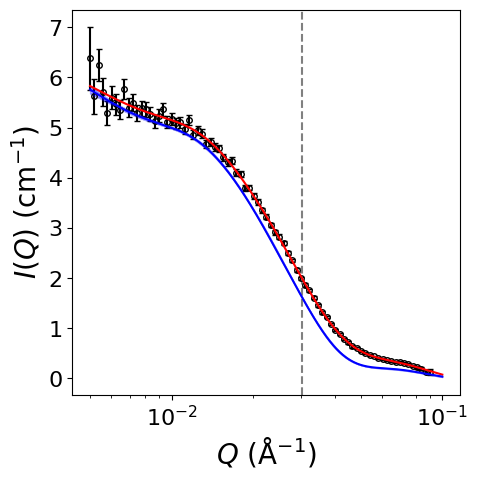

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# from bundle
a_est = bundle['knee']['a_est']
Q_app_fit = bundle['app_fit']['Q']
I_app_fit = bundle['app_fit']['I']
Q_hat_fit = bundle['hat_fit']['Q']
I_hat_fit = bundle['hat_fit']['I']
delta_I_hat_fit = bundle['hat_fit']['dI']
T = bundle['meta']['T']
Q_exp = bundle['exp']['Q']
I_exp = bundle['exp']['I']
delta_I_exp = bundle['exp']['dI']
delta_Q_exp = bundle['exp']['dQ']

# experimental data
# visualize_exp(ax, data)
ax.errorbar(
    Q_exp,
    I_exp,
    yerr=bundle['exp'].get("dI", None),
    # xerr=bundle['exp'].get("dQ", None),
    fmt='o',
    color='k',
    fillstyle='none',
    markersize=4,
    capsize=2,
    label='Experimental data'
)

# knee position
ax.axvline(1/a_est, color='gray', ls='--')

# apparent fit
ax.plot(
    Q_app_fit, I_app_fit,
    '-', color='r',
    zorder=4
)

# reconstructed intrinsic intensity
ax.plot(
    Q_hat_fit, I_hat_fit*(1-T),
    '-', color='blue',
    zorder=5
)

# uncertainty band
ax.fill_between(
    Q_hat_fit,
    (I_hat_fit - delta_I_hat_fit)*(1-T),
    (I_hat_fit + delta_I_hat_fit)*(1-T),
    color='blue',
    alpha=0.3,
    step='mid',
    zorder=2
)

ax.set_xscale('log')
ax.set_xlabel(r'$Q~(\mathrm{\AA^{-1}})$', fontsize=20)
ax.set_ylabel(r'$I(Q)~(\mathrm{cm^{-1}})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)


In [44]:
def bundle_plot(ax, bundle, label=False, Q_err=False, xscale='log'):
    a_est = bundle['knee']['a_est']
    Q_app_fit = bundle['app_fit']['Q']
    I_app_fit = bundle['app_fit']['I']
    Q_hat_fit = bundle['hat_fit']['Q']
    I_hat_fit = bundle['hat_fit']['I']
    delta_I_hat_fit = bundle['hat_fit']['dI']
    T = bundle['meta']['T']
    Q_exp = bundle['exp']['Q']
    I_exp = bundle['exp']['I']
    delta_I_exp = bundle['exp'].get("dI", None)
    delta_Q_exp = bundle['exp'].get("dQ", None)

    handles = []
    legends = []
    # experimental data
    h = ax.errorbar(
        Q_exp,
        I_exp,
        yerr=delta_I_exp,
        xerr=delta_Q_exp if Q_err else None,
        fmt='o',
        color='k',
        fillstyle='none',
        markersize=4,
        capsize=2,
        label='Experimental data'
    )
    handles.append(h)
    legends.append('Experimental data')
    
    # knee position
    ax.axvline(1/a_est, color='gray', ls='--')

    # apparent fit
    h = ax.plot(
        Q_app_fit, I_app_fit,
        '-', color='r',
        zorder=4,
        label='Apparent fit'
    )
    handles.append(h[0])
    legends.append('Apparent fit')

    # reconstructed intrinsic intensity
    h = ax.plot(
        Q_hat_fit, np.array(I_hat_fit)*(1-T),
        '-', color='blue',
        zorder=5,
        label='Reconstructed intrinsic intensity'
    )
    handles.append(h[0])
    legends.append('Reconstructed intrinsic intensity')

    # uncertainty band
    ax.fill_between(
        Q_hat_fit,
        (np.array(I_hat_fit) - np.array(delta_I_hat_fit))*(1-T),
        (np.array(I_hat_fit) + np.array(delta_I_hat_fit))*(1-T),
        color='blue',
        alpha=0.3,
        step='mid',
        zorder=2,
    )
    
    ax.set_xscale(xscale)
    ax.set_xlabel(r'$Q~(\mathrm{\AA^{-1}})$', fontsize=20)
    ax.set_ylabel(r'$I(Q)~(\mathrm{cm^{-1}})$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(handles=handles, labels=legends, fontsize=10, frameon=False)

## 31144 taehwan kim

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9592e+05                                    9.97e+03    
       1              2         1.9364e+05      2.28e+03       2.19e-01       9.97e+03    
       2              3         1.8909e+05      4.55e+03       4.38e-01       9.96e+03    
       3              4         1.8001e+05      9.08e+03       8.76e-01       9.94e+03    
       4              5         1.6199e+05      1.80e+04       1.75e+00       9.85e+03    
       5              6         1.2682e+05      3.52e+04       3.50e+00       9.51e+03    
       6              7         6.3429e+04      6.34e+04       7.01e+00       7.86e+03    
       7              8         1.0100e+03      6.24e+04       1.40e+01       9.20e+02    
       8              9         3.7311e+01      9.73e+02       7.38e+00       1.08e+02    
       9             10         2.7520e+01      9.79e+00       5.72e-01       6.14e+00    

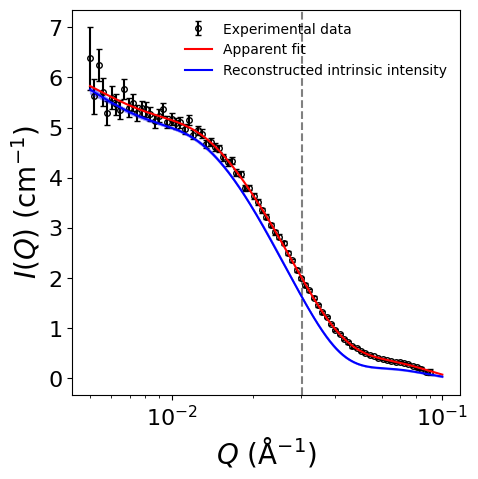

In [45]:
filename = "./data/31144/10_conf1_Iq.dat"
data = load_scattering_data(filename, skiprows=2, comments="#")

bundle = f_demultiple(
    data,
    T=0.665297,
    b=3/2,
    n_max=12,
    power=4.0,
    f_Cjkl=f_Cjkl,
    build_C_tensor=build_C_tensor,
    u_tilde_n_B=u_tilde_n_B,
    reconstruct_from_coeffs=reconstruct_from_coeffs,
    u_n_Q=u_n_Q,
)

# convert
out_json = to_jsonable(bundle)

# save
with open("out_31144_10conf1.json", "w", encoding="utf-8") as f:
    json.dump(out_json, f, indent=2)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
bundle_plot(ax, bundle)

## 30199 SDS100

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3511e+07                                    1.36e+06    
       1              2         2.3747e+07      9.76e+06       5.64e+00       1.07e+06    
       2              3         1.2314e+07      1.14e+07       1.13e+01       4.39e+05    
       3              4         5.4942e+06      6.82e+06       2.26e+01       1.43e+05    
       4              5         2.8749e+06      2.62e+06       4.51e+01       9.11e+04    
       5              6         1.3048e+06      1.57e+06       9.03e+01       3.29e+05    
       6              7         1.0153e+06      2.90e+05       5.58e+00       3.97e+03    
       7              8         1.0152e+06      4.22e+01       4.81e-02       3.43e-01    
       8              9         1.0152e+06      3.44e-07       4.01e-06       2.54e-04    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 3.3511e+07

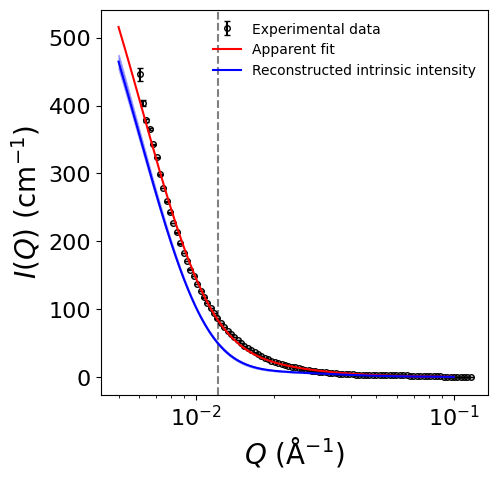

In [135]:
filename = "./data/30199/SDS100_conf1_Iq.dat"
data = load_scattering_data(filename, skiprows=2, comments="#")

bundle = f_demultiple(
    data,
    T=0.749246,
    b=3/2,
    n_max=3,
    power=4.0,
    f_Cjkl=f_Cjkl,
    build_C_tensor=build_C_tensor,
    u_tilde_n_B=u_tilde_n_B,
    reconstruct_from_coeffs=reconstruct_from_coeffs,
    u_n_Q=u_n_Q,
    
    frac = 0.5,  # if None -> exp(-1)
    Q_fine_min = 5e-3,
    Q_fine_max = 1e-1,
    N_fine = 1000,
    Q_obs_min = 5e-3,
    Q_obs_max = 1e-1,
    N_obs = 300,
)

# convert
out_json = to_jsonable(bundle)

# save
with open("out_30199_SDS100_conf1.json", "w", encoding="utf-8") as f:
    json.dump(out_json, f, indent=2)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
bundle_plot(ax, bundle)

## 34658

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.1307e+03                                    1.75e+02    
       1              2         5.1081e+03      2.26e+01       1.17e-01       1.75e+02    
       2              3         5.0629e+03      4.52e+01       2.34e-01       1.75e+02    
       3              4         4.9727e+03      9.02e+01       4.67e-01       1.74e+02    
       4              5         4.7928e+03      1.80e+02       9.35e-01       1.74e+02    
       5              6         4.4356e+03      3.57e+02       1.87e+00       1.72e+02    
       6              7         3.7349e+03      7.01e+02       3.74e+00       1.66e+02    
       7              8         2.4218e+03      1.31e+03       7.48e+00       1.49e+02    
       8              9         5.3927e+02      1.88e+03       1.50e+01       7.10e+01    
       9             10         5.3900e+01      4.85e+02       2.74e+01       2.99e+01    

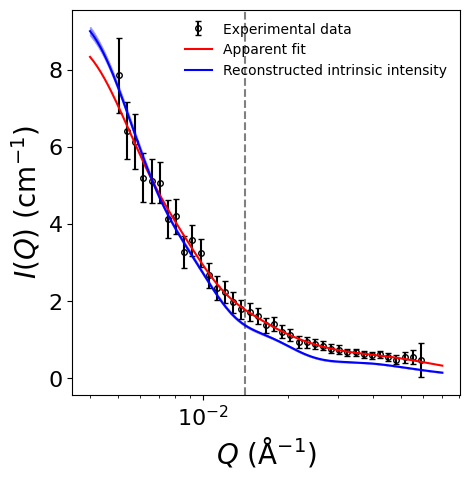

In [137]:
filename = "./data/34658/2p5lp-12cs-1k_conf1_el_Iq.dat"
data = load_scattering_data(filename, skiprows=2, comments="#")

bundle = f_demultiple(
    data,
    T=0.684800,
    b=3/2,
    n_max=10,
    power=4.0,
    f_Cjkl=f_Cjkl,
    build_C_tensor=build_C_tensor,
    u_tilde_n_B=u_tilde_n_B,
    reconstruct_from_coeffs=reconstruct_from_coeffs,
    u_n_Q=u_n_Q,
    
    frac = 0.5,  # if None -> exp(-1)
    Q_fine_min = 4e-3,
    Q_fine_max = 7e-2,
    N_fine = 1000,
    Q_obs_min = 4e-3,
    Q_obs_max = 7e-2,
    N_obs = 200,
    
    n_low=5,
    n_blend_low=7,
    penalty_coeff=1e-3,
    
    Q_exp_min = 5e-3,
)

# convert
out_json = to_jsonable(bundle)

# save
with open("out_34658_2p5lp-12cs-1k_conf1_el.json", "w", encoding="utf-8") as f:
    json.dump(out_json, f, indent=2)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
bundle_plot(ax, bundle)

## 33335

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1629e+06                                    3.13e+04    
       1              2         9.8446e+05      1.78e+05       5.25e+00       1.96e+04    
       2              3         7.8746e+05      1.97e+05       1.05e+01       1.05e+04    
       3              4         5.4664e+05      2.41e+05       2.10e+01       6.11e+03    
       4              5         3.0975e+05      2.37e+05       4.20e+01       2.17e+03    
       5              6         1.2829e+05      1.81e+05       8.40e+01       3.14e+03    
       6              7         5.7370e+04      7.09e+04       1.68e+02       1.04e+04    
       7              8         5.6688e+04      6.82e+02       3.36e+02       1.97e+04    
       8              9         6.4825e+03      5.02e+04       8.40e+01       6.89e+02    
       9             10         5.1877e+03      1.29e+03       8.47e+01       1.43e+03    

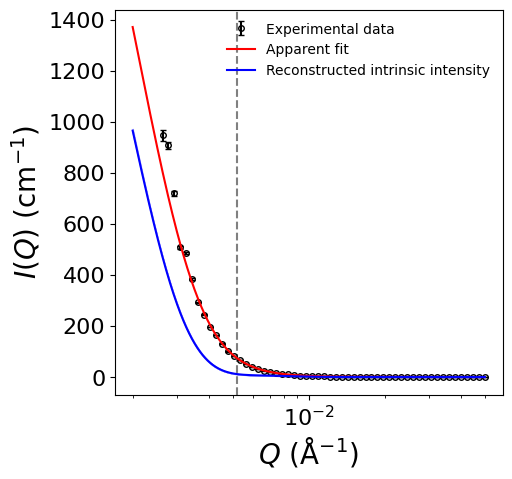

In [193]:
filename = "./data/33335/s0_35C_conf1_Iq.dat"
data = load_scattering_data(filename, skiprows=2, comments="#")

bundle = f_demultiple(
    data,
    T=0.693475,
    b=3/2,
    n_max=5,
    power=4.0,
    f_Cjkl=f_Cjkl,
    build_C_tensor=build_C_tensor,
    u_tilde_n_B=u_tilde_n_B,
    reconstruct_from_coeffs=reconstruct_from_coeffs,
    u_n_Q=u_n_Q,
    
    frac = 0.5,  # if None -> exp(-1)
    Q_fine_min = 2e-3,
    Q_fine_max = 5e-2,
    N_fine = 1000,
    Q_obs_min = 2e-3,
    Q_obs_max = 5e-2,
    N_obs = 400,
    
    n_low=2,
    n_blend_low=4,
    penalty_coeff=1e-5,
    
    Q_exp_min = 1e-3,
    Q_exp_max = 0.2,
)

# convert
out_json = to_jsonable(bundle)

# save
with open("out_33335_s0_35C_conf1.json", "w", encoding="utf-8") as f:
    json.dump(out_json, f, indent=2)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
bundle_plot(ax, bundle)

## 30199 SDS100

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3511e+07                                    1.36e+06    
       1              2         2.3747e+07      9.76e+06       5.64e+00       1.07e+06    
       2              3         1.2314e+07      1.14e+07       1.13e+01       4.39e+05    
       3              4         5.4942e+06      6.82e+06       2.26e+01       1.43e+05    
       4              5         2.8749e+06      2.62e+06       4.51e+01       9.11e+04    
       5              6         1.3048e+06      1.57e+06       9.03e+01       3.29e+05    
       6              7         1.0153e+06      2.90e+05       5.58e+00       3.97e+03    
       7              8         1.0152e+06      4.22e+01       4.81e-02       3.43e-01    
       8              9         1.0152e+06      3.44e-07       4.01e-06       2.54e-04    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 3.3511e+07

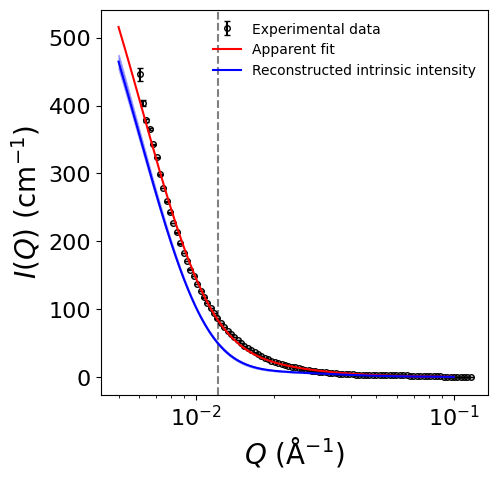

In [ ]:
filename = "./data/30199/SDS100_conf1_Iq.dat"
data = load_scattering_data(filename, skiprows=2, comments="#")

bundle = f_demultiple(
    data,
    T=0.749246,
    b=3/2,
    n_max=3,
    power=4.0,
    f_Cjkl=f_Cjkl,
    build_C_tensor=build_C_tensor,
    u_tilde_n_B=u_tilde_n_B,
    reconstruct_from_coeffs=reconstruct_from_coeffs,
    u_n_Q=u_n_Q,
    
    frac = 0.5,  # if None -> exp(-1)
    Q_fine_min = 5e-3,
    Q_fine_max = 1e-1,
    N_fine = 1000,
    Q_obs_min = 5e-3,
    Q_obs_max = 1e-1,
    N_obs = 300,
)

# convert
out_json = to_jsonable(bundle)

# save
with open("out_30199_SDS100_conf1.json", "w", encoding="utf-8") as f:
    json.dump(out_json, f, indent=2)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
bundle_plot(ax, bundle)

## 35884 s0_conf1

/tmp/ipykernel_3120598/444528790.py:166: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, err = quad(


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5136e+07                                    7.79e+05    
       1              2         1.2557e+07      2.58e+06       2.62e+00       5.32e+05    
       2              3         9.7990e+06      2.76e+06       5.24e+00       2.90e+05    
       3              4         6.8340e+06      2.97e+06       1.05e+01       1.54e+05    
       4              5         3.6420e+06      3.19e+06       2.10e+01       6.12e+04    
       5              6         1.1313e+06      2.51e+06       4.19e+01       3.85e+04    
       6              7         2.3367e+05      8.98e+05       8.38e+01       5.45e+04    
       7              9         8.1376e+04      1.52e+05       4.19e+01       7.39e+03    
       8             10         5.1847e+04      2.95e+04       8.38e+01       3.73e+04    
       9             11         2.4313e+04      2.75e+04       8.38e+01       1.30e+04    

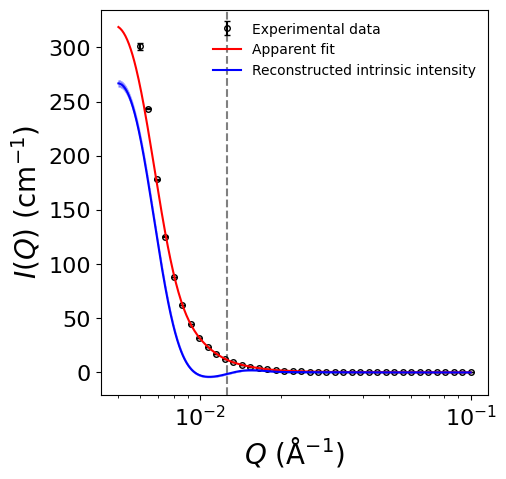

In [136]:
filename = "./data/35884/s0_conf1_Iq.dat"
data = load_scattering_data(filename, skiprows=2, comments="#")

bundle = f_demultiple(
    data,
    T=0.707382,
    b=3/2,
    n_max=15,
    power=4.0,
    f_Cjkl=f_Cjkl,
    build_C_tensor=build_C_tensor,
    u_tilde_n_B=u_tilde_n_B,
    reconstruct_from_coeffs=reconstruct_from_coeffs,
    u_n_Q=u_n_Q,
    
    frac = 0.5,  # if None -> exp(-1)
    Q_fine_min = 5e-3,
    Q_fine_max = 1e-1,
    N_fine = 1000,
    Q_obs_min = 5e-3,
    Q_obs_max = 1e-1,
    N_obs = 400,
    
    n_low=5,
    n_blend_low=7,
    penalty_coeff=1e-3,
)

# convert
out_json = to_jsonable(bundle)

# save
with open("out_35884_s0_conf1.json", "w", encoding="utf-8") as f:
    json.dump(out_json, f, indent=2)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
bundle_plot(ax, bundle)

## 33357

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2916e+06                                    1.18e+06    
       1              2         2.0332e+06      2.26e+06       5.32e+01       1.28e+06    
       2              3         2.7388e+05      1.76e+06       5.32e+01       2.95e+05    
       3              5         8.5030e+04      1.89e+05       2.66e+01       1.74e+05    
       4              7         7.0283e+04      1.47e+04       1.33e+01       2.56e+04    
       5              8         6.1827e+04      8.46e+03       2.66e+01       7.57e+04    
       6              9         5.7886e+04      3.94e+03       5.32e+01       1.84e+05    
       7             10         4.8016e+04      9.87e+03       4.69e+01       1.33e+05    
       8             11         4.4967e+04      3.05e+03       1.11e+01       5.24e+03    
       9             12         4.4938e+04      2.83e+01       3.46e+00       6.65e+02    

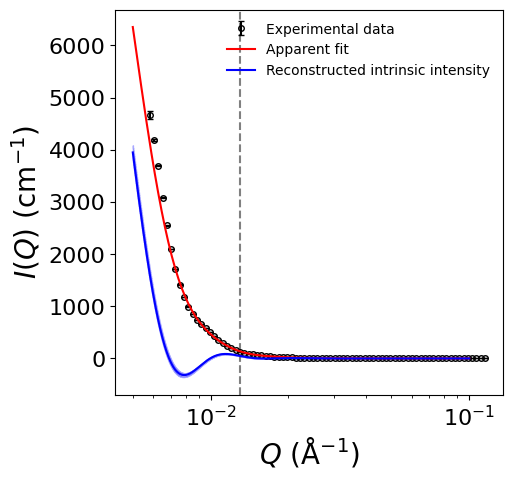

In [156]:
filename = "./data/33357/si30_1peg_20C_4m10a_bfit_Iq.dat"
data = load_scattering_data(filename, skiprows=2, comments="#")

bundle = f_demultiple(
    data,
    T=0.410308,
    b=3/2,
    n_max=10,
    power=4.0,
    f_Cjkl=f_Cjkl,
    build_C_tensor=build_C_tensor,
    u_tilde_n_B=u_tilde_n_B,
    reconstruct_from_coeffs=reconstruct_from_coeffs,
    u_n_Q=u_n_Q,
    
    frac = 0.65,  # if None -> exp(-1)
    Q_fine_min = 5e-3,
    Q_fine_max = 1e-1,
    N_fine = 1000,
    Q_obs_min = 5e-3,
    Q_obs_max = 1e-1,
    N_obs = 200,
    
    n_low=2,
    n_blend_low=3,
    penalty_coeff=1e-3,
    
    Q_exp_min = 2e-3,
    Q_exp_max = 0.2,
)

# convert
out_json = to_jsonable(bundle)

# save
with open("out_33357_si30_1peg_20C_4m10a_bfit.json", "w", encoding="utf-8") as f:
    json.dump(out_json, f, indent=2)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
bundle_plot(ax, bundle)